In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
names = open('./data/cleaned-turkish-names.txt', 'r').read().splitlines()
names[:8]

['aba', 'abaca', 'abacan', 'abay', 'abayhan', 'abaza', 'abaç', 'abbas']

In [3]:
len(names)

9248

In [ ]:
# words = []

# for name in names:
#     name_splitted = name.split()
#     words.extend(name_splitted)

# len(words)

2864

In [4]:
words = list(set(names))
'words after removing duplicates', len(words)

('words after removing duplicates', 9248)

In [6]:
# with open('cleaned-names-tr.txt', 'w', encoding='utf-8') as file:
#     for word in words:
#         file.write(word+ '\n')

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print('itos: ', itos)
print('stoi: ', stoi)

itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'y', 23: 'z', 24: 'ç', 25: 'ö', 26: 'ü', 27: 'ğ', 28: 'ı', 29: 'ş', 0: '.'}
stoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'y': 22, 'z': 23, 'ç': 24, 'ö': 25, 'ü': 26, 'ğ': 27, 'ı': 28, 'ş': 29, '.': 0}


In [6]:
N = torch.zeros((30,30), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        N[ix1, ix2] +=1

(np.float64(-0.5), np.float64(29.5), np.float64(29.5), np.float64(-0.5))

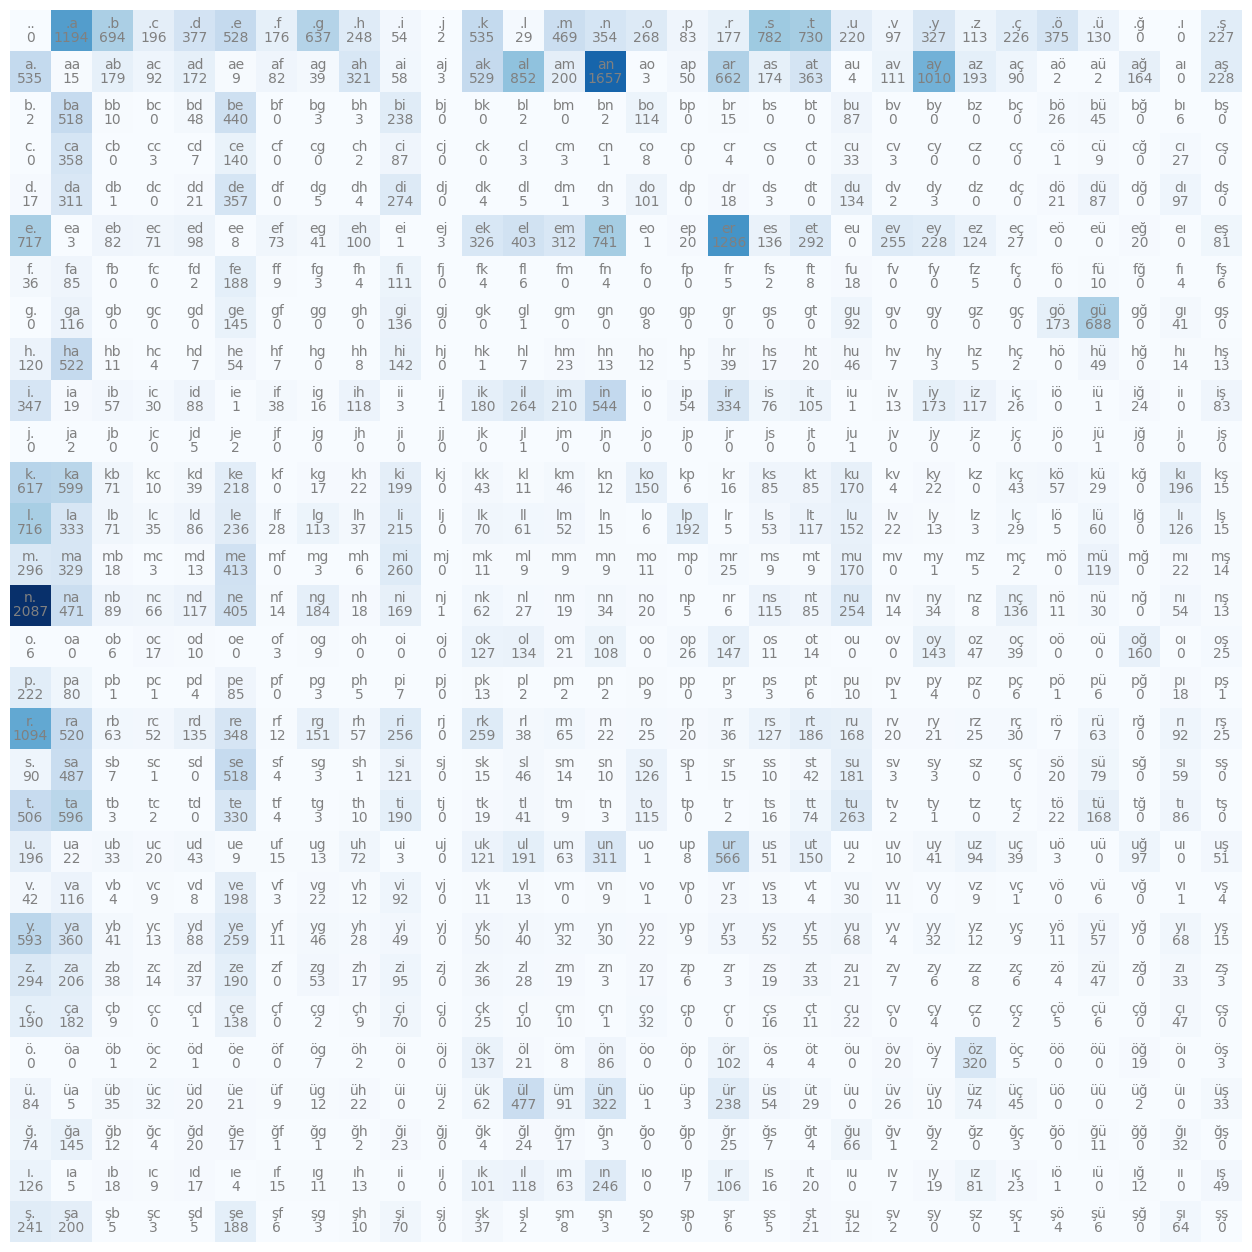

In [8]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(30):
    for j in range(30):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha= 'center', va= 'bottom', color = 'gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
        
plt.axis('off')

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([52807, 3]) torch.Size([52807])
torch.Size([6557, 3]) torch.Size([6557])
torch.Size([6551, 3]) torch.Size([6551])


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((30, 10), generator=g, requires_grad=True)  # embedding layer
W1 = torch.randn((30, 200), generator=g, requires_grad=True)    
b1 = torch.randn(200, generator=g, requires_grad=True)
W2 = torch.randn((200, 30), generator=g, requires_grad=True)
b2 = torch.randn(30, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [14]:
sum(p.nelement() for p in parameters) # number of parameters in total

12530

In [ ]:
# for p in parameters:
#   p.requires_grad = True

In [15]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [16]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # [32, 3, 10]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 30)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

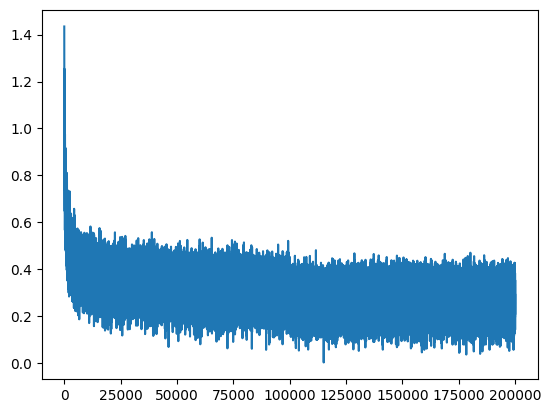

In [18]:
plt.plot(stepi, lossi)

In [19]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 30)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9037, grad_fn=<NllLossBackward0>)

In [20]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 30)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1238, grad_fn=<NllLossBackward0>)

In [21]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 30)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1393, grad_fn=<NllLossBackward0>)

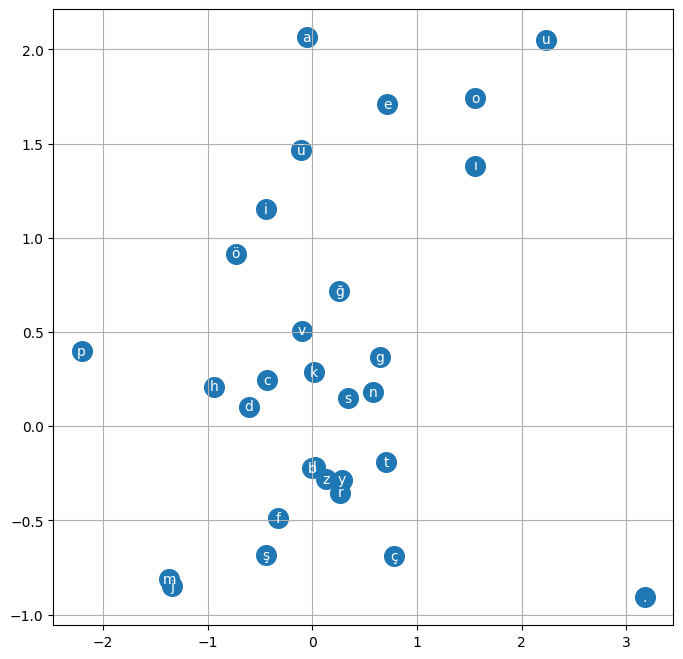

In [22]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [26]:
# sample from the model
g = torch.Generator().manual_seed(1337)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

gülşennulyetsuphiye.
üneç.
gim.
bozdoğgülhan.
zir.
tez.
aşınbike.
sabat.
aman.
güçalgam.
durdar.
men.
safhun.
ördelüpkin.
say.
özgen.
ruhan.
görgüçan.
gülgül.
rezkutsevvan.
